# Failure Mode Demonstration Notebook

A notebook to demonstrate some of the features of the Failure Mode class

Author: gavin.treseder@essentialenergy.com.au

Table of Contents

### Timelines
#### Start State
##### Perfect starting condition
##### Condition loss




# Overview
The FailureMode class is used to represent a failure mode that can affect an asset. It inlcudes:
- Conditions. A ConditionIndicator class that represents condtions that can be impacted by the failure mode.
- Tasks. A Task class task that represents an action that can be performed on a failure mode (see task class)


## Libraries

Several packages are required to use the FailureMode class

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [6]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *
import pof.demo as demo

from config import config
cf = config['FailureMode']

fm = FailureMode.demo()

## Single timeline
A timeline is the fundamental building block from which cost, risk and performance will be calculated. A single timeline represents all the potential state, condition and tasks that affect an asset over the target time

### Perfect Condition
Generate a single timeline to show the state of the failure mode, its condition and the days until a task is triggered over time.

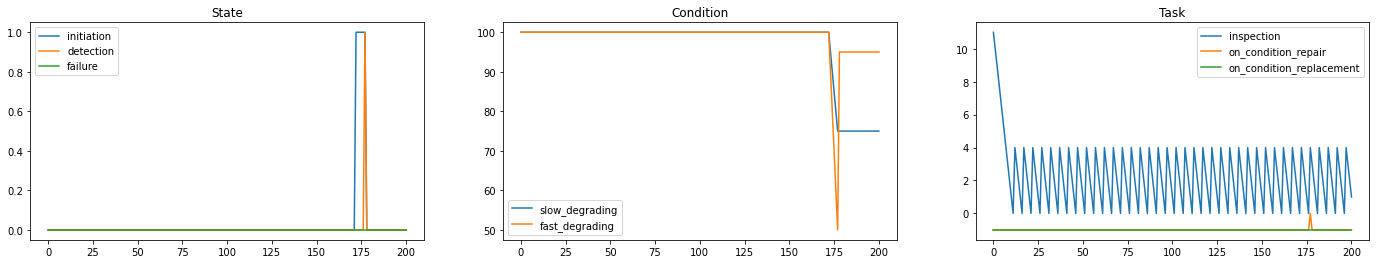

In [8]:
timeline = fm.sim_timeline(200)
fm.plot_timeline()

### Degraded Condition
The simulation above assumes that the failure mode is in perfect condition while the simulation below starts with some accumulated damage.
The 

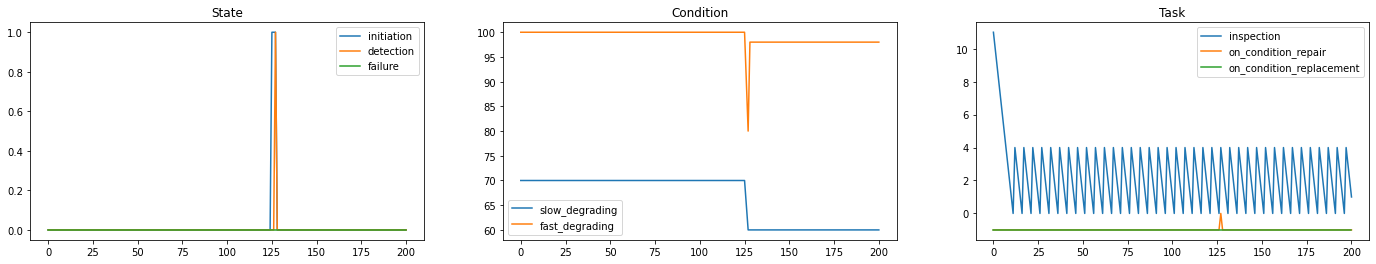

In [13]:
fm.reset()
fm.indicators['slow_degrading'].set_condition(70)
fm.sim_timeline(200)
fm.plot_timeline()

## Remain Failed

In [20]:
fm.tasks['on_condition_repair'].__dict__

{'_name': 'on_condition_repair',
 'task_type': 'immediate',
 'trigger': 'condition',
 'active': True,
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100,
 'labour': NotImplemented,
 'spares': NotImplemented,
 'equipment': NotImplemented,
 'consequence': <pof.consequence.Consequence at 0x2914ebb2280>,
 'p_effective': 0.7,
 'triggers': {'condition': {'fast_degrading': {'lower': 20, 'upper': 90},
   'slow_degrading': {'lower': 20, 'upper': 90}},
  'state': {'detection': True},
  'time': {}},
 'impacts': {'condition': {'fast_degrading': {'target': 0.9,
    'method': 'reduction_factor',
    'axis': 'condition'},
   'slow_degrading': {'target': 0,
    'method': 'reduction_factor',
    'axis': 'condition'}},
  'state': {'initiation': False, 'detection': False, 'failure': False},
  'system': ['fm'],
  'time': {}},
 'state': NotImplemented,
 't_completion': [0],
 'cost_completion': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  1

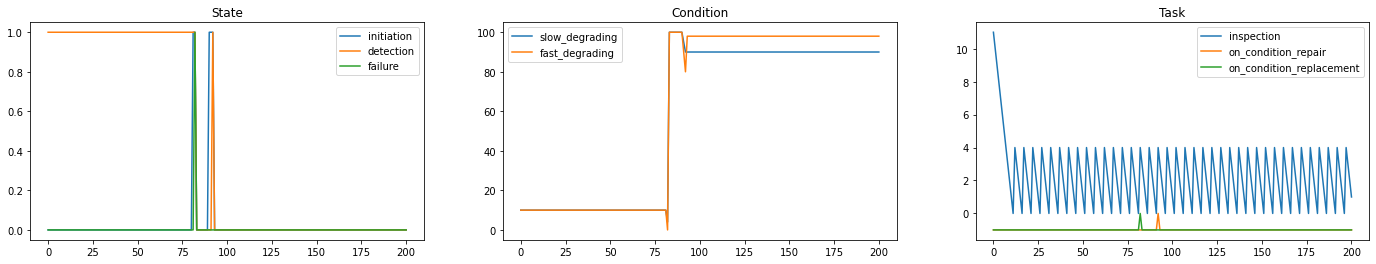

In [21]:
cf['remain_failed'] = 'False'
fm.reset()
fm.indicators['slow_degrading'].set_condition(10)
fm.indicators['fast_degrading'].set_condition(10)
fm.set_states(dict(initiation=True, detection=True))
fm.sim_timeline(200)
fm.plot_timeline()


In [22]:
fm.timeline

{'time': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 

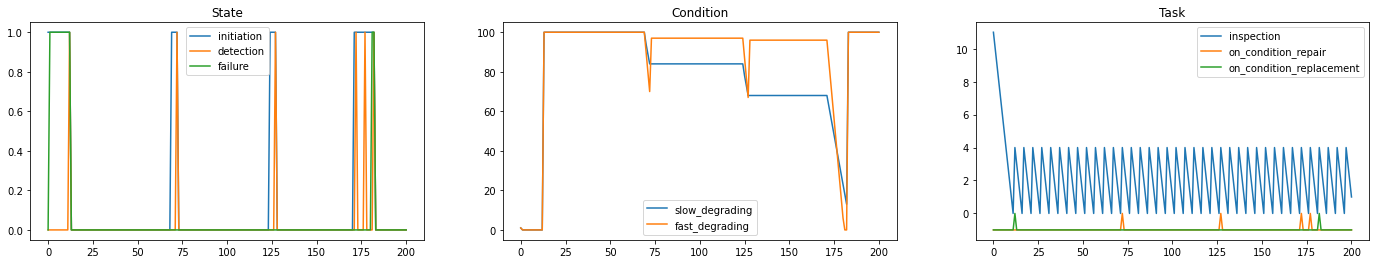

In [15]:
cf['remain_failed'] = 'False'
fm.reset()
fm.set_states({'initiation':True})
fm.indicators['slow_degrading'].set_condition(1)
fm.indicators['fast_degrading'].set_condition(1)
fm.sim_timeline(200)
fm.plot_timeline()

## Maintenance Strategy

The maintenance strategy...

In [10]:
import cProfile
p = cProfile.Profile()
p.enable()

fm = FailureMode().set_demo()

fm.mc_timeline(t_end=2000, n_iterations=100)

df = fm.expected_risk_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()
p.disable()
p.dump_stats("results.prof")

100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


In [12]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI     Upper CI
Parameter                                                         
Alpha          913.419298      213.699360  577.466774  1444.818735
Beta             1.506197        0.184067    1.185385     1.913834
Gamma           46.553065       10.229872   30.262148    71.613816
Log-Likelihood: -571.0140388868822


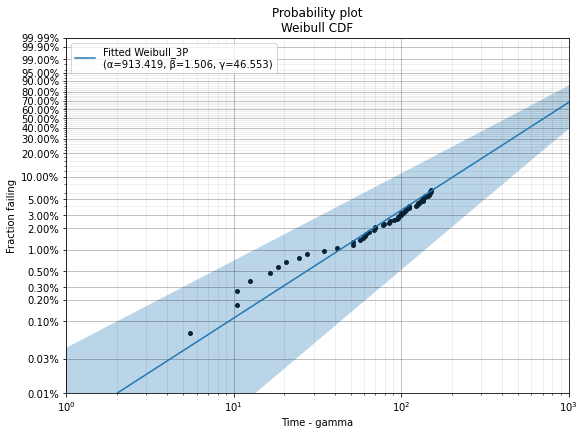

In [7]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored);

## Condition

In [20]:
from pof.interface.figures import update_condition_fig

update_condition

**Explain how the distribution needs to be adjusted based on the gamma and pf_interval



In [22]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm._expected_cost()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:07<00:00, 126.12it/s]


In [23]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [14]:
fm.mc_timeline(1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


In [15]:
test = np.array([True, True, True, False])

test.mean()

0.75

In [16]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:02<00:00, 47.39it/s]1.88 s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [17]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:01<00:00, 66.46it/s]2.06 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

